# **Part 0 : libs installing & func init**

In [ ]:
# need to be installed if it's not
!pip install Ninja

In [ ]:
!python model.py install

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torchvision import transforms

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

def img_to_tensor(img):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(img)

def tensor_to_img(tensor):
    conv = transforms.ToPILImage()
    return conv(tensor)

In [ ]:
import torch
from torchvision import utils
from model import Generator
from tqdm import tqdm
from PIL import Image
import math


def generator_params(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device="cuda"):
    return (img_size, latent_len, n_mlp, chanel_miltiplier, ckpt, device)

def init_generator(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device="cuda"):
    """
    small docs : 
    img_size = 1024 # output image size of the generator
    latent = 512
    n_mlp = 8
    channel_multiplier = 2
    ckpt = 'stylegan2-ffhq-config-f.pt' # channel multiplier of the generator. config-f = 2, else = 1
    """

    g_ema = Generator(img_size, latent_len, n_mlp, channel_multiplier=chanel_miltiplier).to(device)
    checkpoint = torch.load(ckpt)
    g_ema.load_state_dict(checkpoint["g_ema"], strict=False)

    return g_ema


# **Part 1**
Here we use StyleGAN-2 to generate image that we want to get as a result

In [ ]:
! rm -f /content/stylegan2-pytorch/sample/*

In [ ]:
#global variables

latent_len = 512
device = 'cuda'
torch.manual_seed(42)
truncation = 0.7
img_size=256

generator = init_generator(ckpt = 'C:/Users/Tony/Downloads/550000.pt', img_size=img_size)
trunc = generator.mean_latent(int(math.log(img_size, 2)) * 2 - 2)


C:\Users\Tony\AppData\Local\Temp\ipykernel_4812\3375661814.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w = torch.tensor(generator.get_latent(sample_z))


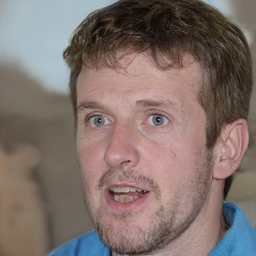

In [ ]:
torch.manual_seed(42)

sample_z = torch.randn(1, latent_len, dtype=torch.float32, device=torch.device(device))
latent_w = torch.tensor(generator.get_latent(sample_z))

goal_image, goal_latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)

utils.save_image(
    goal_image,
    f"sample/goal.png",
    nrow=1,
    normalize=True,
    range=(-1, 1),
)

goal_image.to(device)

goal_img = Image.open('sample/goal.png')
goal_img

# **Part 2**
Here we will generate a new image and try to get image from part 1 impoving latent_w

In [ ]:
torch.manual_seed(12)

sample_z = torch.randn(1, latent_len, dtype=torch.float32, device=torch.device(device))
latent_w = torch.tensor(generator.get_latent(sample_z))

input_image, input_latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)

#input_img = Image.open('sample/input.png')
#input_img

C:\Users\Tony\AppData\Local\Temp\ipykernel_4812\2040123596.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w = torch.tensor(generator.get_latent(sample_z))


In [ ]:
from torch import nn

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

loss_points = []
latent_w = torch.tensor(input_latent, requires_grad=True)
learning_rate = 0.1
loss_fn = nn.MSELoss()

for i in range(100000):
    step = i % 10000 # [0, ..., 9]
    if step < 9:
        learning_rate = 0.1
    else:
        learning_rate = 0.01
    optimizer = torch.optim.SGD([latent_w], lr=learning_rate, momentum=0.9)
    optimizer.zero_grad()
    gan_image, latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)
    loss = loss_fn(gan_image.to(device), goal_image)
    loss_points.append(loss.item())
    if i % 10000 == 0:
        print('loss', loss.item())
        utils.save_image(
            gan_image,
            f"sample/{str(i).zfill(6)}.png",
            nrow=1,
            normalize=True,
            range=(-1, 1),
        )
    latent_w.requires_grad_()
    loss.backward(retain_graph=True)
    optimizer.step()


utils.save_image(
    gan_image,
    f"sample/final.png",
    nrow=1,\
    normalize=True,
    range=(-1, 1),
)

1
NVIDIA GeForce RTX 3090
loss 0.18279241025447845


C:\Users\Tony\AppData\Local\Temp\ipykernel_4812\3408304913.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w = torch.tensor(input_latent, requires_grad=True)


loss 0.13771143555641174
loss 0.1197725385427475
loss 0.1118682250380516
loss 0.10677605867385864
loss 0.10395544767379761
loss 0.10248013585805893
loss 0.10000936686992645
loss 0.09913095086812973
loss 0.0979142040014267


# **Results**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_loss(y_points, title = 'Loss'):
    x_points = np.arange(0, len(y_points))

    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=18, fontname='Times New Roman')
    plt.xlabel('Epoch', fontsize=16, fontname='Times New Roman')
    plt.ylabel('Score', fontsize=16, fontname='Times New Roman')
    plt.plot(x_points, y_points, color='#fb607f', linestyle='-')
    #plt.legend([''], loc='center', shadow=True, fontsize=18)
    plt.show()

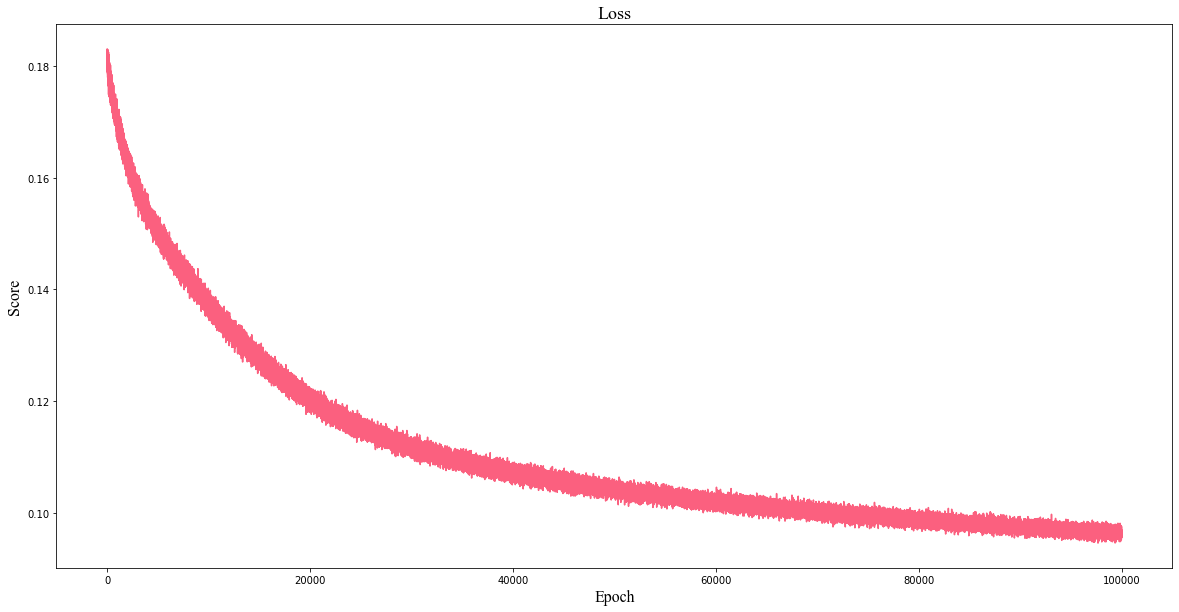

In [ ]:
plot_loss(loss_points)

In [ ]:
import os

def plot_pictures():
    images = []
    #images.append(Image.open('/content/drive/MyDrive/КУ Курсачи/Диплом/000003.png'))

    res_dir = 'sample'
    list_dirs = os.listdir(res_dir)
    list_dirs.sort()
    for cur_file in list_dirs:
        images.append(Image.open(os.path.join(res_dir, cur_file)))

    fig = plt.figure(figsize=(10, 10))
    cols = 3
    rows = 4

    ax = []

    for i in range(cols * rows):
        image = images[i]
        ax.append(fig.add_subplot(rows, cols, i + 1))
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()


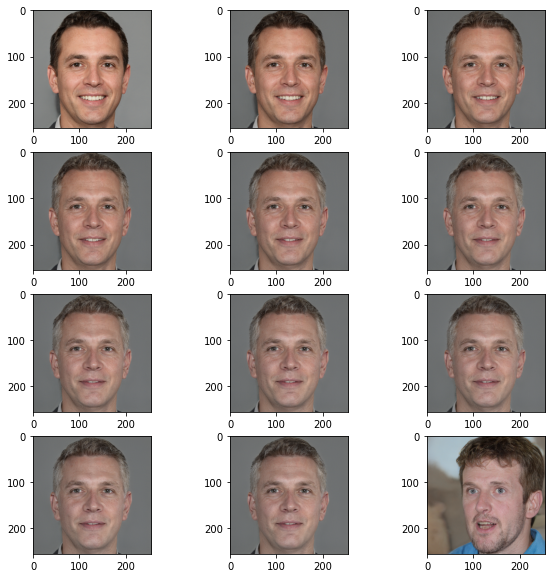

In [ ]:
plot_pictures()

In [ ]:
print('final loss:', loss_points[len(loss_points) - 1])

final loss: 0.0958712249994278
